In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL, poly_kernel, gauss_kernel, scoring


def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y)

    model.fit(X_train, y_train)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cr = ClassificationReport(model, classes=[-1, 1], ax=ax)
    cr.fit(X_train, y_train)
    cr.score(X_test, y_test)
    cr.poof()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cm = ConfusionMatrix(model, classes=[-1, 1], ax=ax)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    rocauc = ROCAUC(model, classes=[-1, 1], ax=ax)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    if not isinstance(model, BEMKL):
        model = model.named_steps['bemkl']
    model.plot_e(rug=True, kde=True, norm_hist=True, ax=ax,
                 rug_kws={'color': 'r', 'linewidth': 2,
                          'alpha': 1})
    
    model_cv = clone(model)
    scoring.iteration = 0
    folds = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
    return cross_validate(model_cv, X, y, cv=folds, scoring=scoring)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
display(X.shape, y.shape, y.mean())

(683, 9)

(683,)

-0.3001464128843338

In [4]:
kernels = [lambda A, B: gauss_kernel(A, B, 2**i) for i in range(-3, 7)]
kernels += [lambda A, B: poly_kernel(A, B, 0, i) for i in range(1, 4)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i) for i in range(-3, 7) for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 0, i) for i in range(1, 4) for j in range(D)]
len(kernels)

130

In [65]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9, null_threshold=1e-3)
normalizer = Normalizer()
sparse_pipeline = make_pipeline(normalizer, sparse_model)
sparse_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(alpha_gamma=1, alpha_lambda=1, alpha_omega=1e-11, beta_gamma=1,
   beta_lambda=1, beta_omega=1000000000.0,
   kernels=[<function <listcomp>.<lambda> at 0x7f0ec42f5598>, <function <listcomp>.<lambda> at 0x7f0ec42f5620>, <functio...   margin=1, max_iter=200, null_threshold=0.001, random_state=None,
   sigma_g=0.1, verbose=False))])

# Sparse model

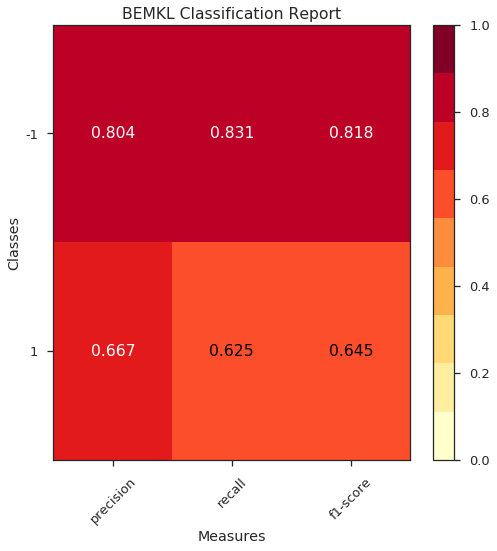

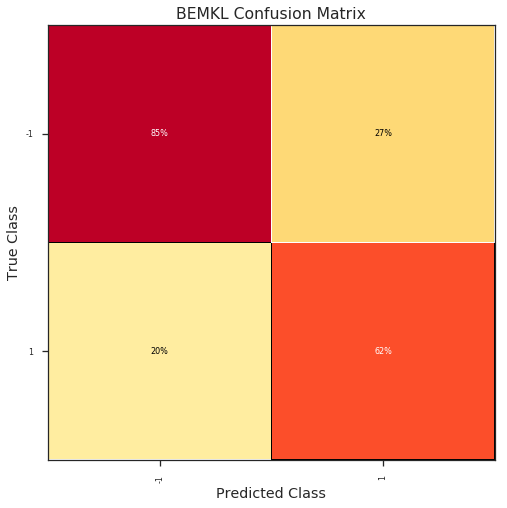

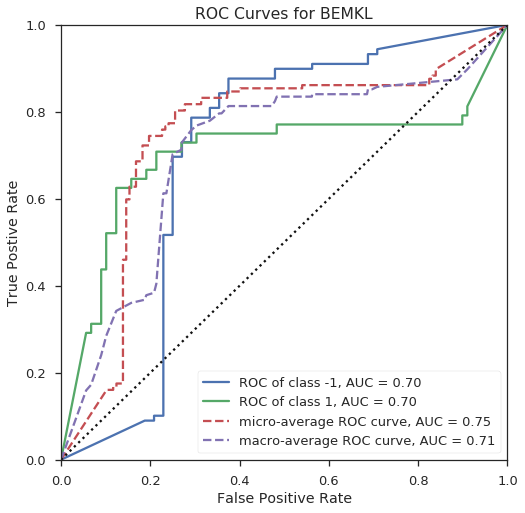

0 - Non-0: 127. Total: 130. Ratio: 0.9769230769230769. Mean e: 0.0325. Median e: 0.0161. Std e: 0.0677. 
1 - Non-0: 127. Total: 130. Ratio: 0.9769230769230769. Mean e: 0.0319. Median e: 0.0159. Std e: 0.0670. 
2 - Non-0: 127. Total: 130. Ratio: 0.9769230769230769. Mean e: 0.0335. Median e: 0.0178. Std e: 0.0674. 
3 - Non-0: 127. Total: 130. Ratio: 0.9769230769230769. Mean e: 0.0320. Median e: 0.0162. Std e: 0.0673. 
4 - Non-0: 127. Total: 130. Ratio: 0.9769230769230769. Mean e: 0.0330. Median e: 0.0172. Std e: 0.0669. 
5 - Non-0: 127. Total: 130. Ratio: 0.9769230769230769. Mean e: 0.0333. Median e: 0.0176. Std e: 0.0659. 


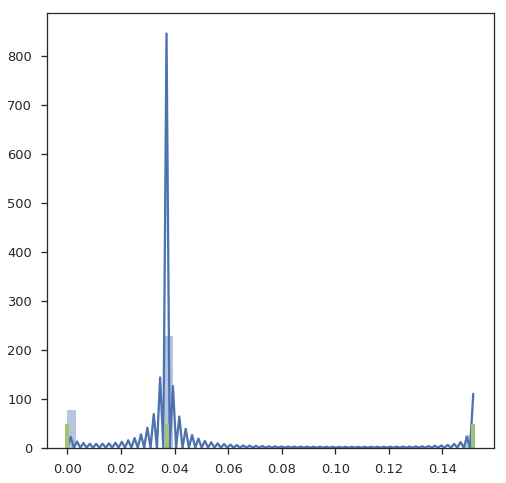

In [11]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9, null_threshold=1e-3)
sparse_pipeline = make_pipeline(Normalizer(), sparse_model)
evaluate_model(sparse_pipeline, X, y)

# Non-sparse Model

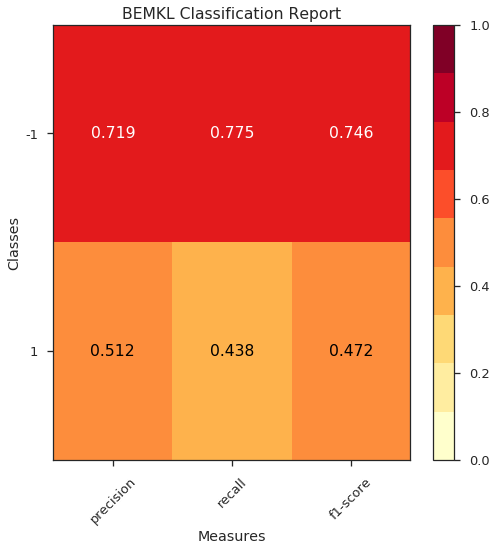

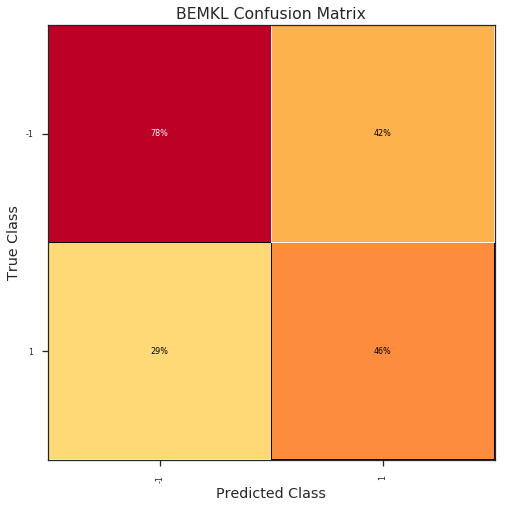

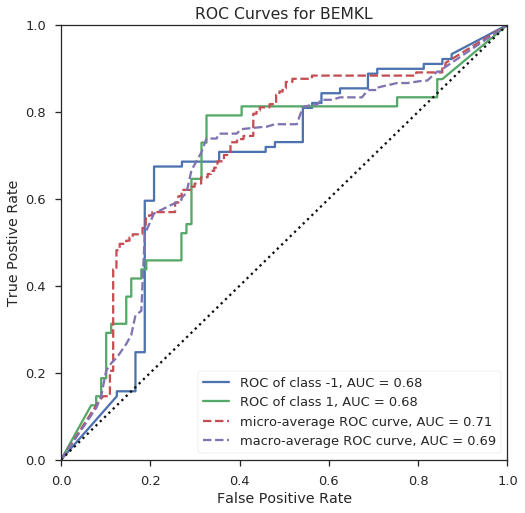

0 - Non-0: 130. Total: 130. Ratio: 1.0. Mean e: 0.0421. Median e: 0.0234. Std e: 0.0573. 
1 - Non-0: 130. Total: 130. Ratio: 1.0. Mean e: 0.0425. Median e: 0.0242. Std e: 0.0561. 
2 - Non-0: 130. Total: 130. Ratio: 1.0. Mean e: 0.0424. Median e: 0.0249. Std e: 0.0585. 
3 - Non-0: 130. Total: 130. Ratio: 1.0. Mean e: 0.0406. Median e: 0.0220. Std e: 0.0621. 
4 - Non-0: 130. Total: 130. Ratio: 1.0. Mean e: 0.0413. Median e: 0.0228. Std e: 0.0582. 
5 - Non-0: 130. Total: 130. Ratio: 1.0. Mean e: 0.0413. Median e: 0.0235. Std e: 0.0572. 


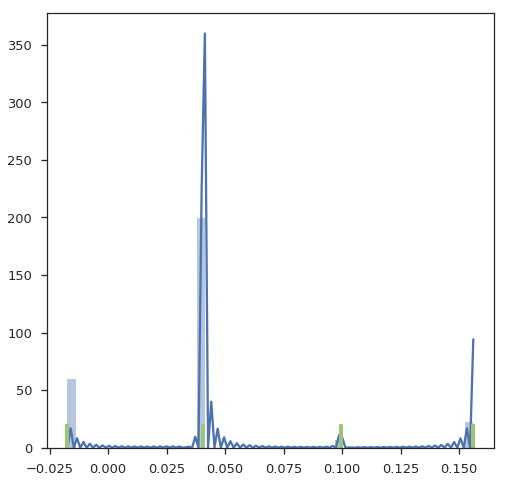

In [12]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1, null_threshold=1e-3)
normal_pipeline = make_pipeline(Normalizer(), normal_model)
evaluate_model(normal_pipeline, X, y)